# <b> Twitter Sentiment Analysis </b>

## <b> Problem Statement </b>
In the era of social media, it is crucial for businesses to understand the sentiments expressed by customers towards their brands or products.
This sentiment analysis project aims to analyze Twitter data and extract valuable insights regarding the sentiments associated with Apple and Google products mentioned in tweets. By uncovering the public's opinions and emotions, businesses can make data-driven decisions to improve their market positioning and enhance customer satisfaction

## <b> Objectives </b>

Our main objective is to create a model that when given a tweet or series of tweets and a product would determine how the user felt about that product.

This is trivial for a human to accomplish, our model can do this for thousands or even millions of tweets in a short time.

1. To build a text classifier to accurately distinguish between positive, neutral, and negative sentiments.

2. Competitive Analysis – Compare the sentiment towards Apple and Google products to identify any significant differences in public perception. 


3. Give insights as to where the company can increase customer satisfaction.

# Data Understanding

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
import itertools
import imblearn.pipeline 
import warnings
warnings.filterwarnings('ignore')


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import TweetTokenizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, precision_score, accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('Data/crowdflower_tweet_data.csv', encoding = 'latin1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
data.shape

(9093, 3)

In [4]:
data.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [5]:
data['emotion_in_tweet_is_directed_at'].value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: emotion_in_tweet_is_directed_at, dtype: float64

In [6]:
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [9]:
data.duplicated().sum()

22

In [10]:
data[data.duplicated()].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion


# Data Cleaning


In [11]:
# Renaming columns
data.columns = ['Tweet', 'Product/Brand', 'Emotion']
data

,Tweet,Product/Brand,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [12]:
data = data.dropna(subset=['Tweet'])

In [13]:
data['Product/Brand'].fillna("Unknown Product", inplace = True)
data.isna().sum()

Tweet            0
Product/Brand    0
Emotion          0
dtype: int64

In [14]:
data.drop_duplicates(keep='first', inplace=True)

In [15]:
emotion = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
data['Emotion'] = data['Emotion'].map(emotion)
data.head()

,Tweet,Product/Brand,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [16]:
data['Emotion'].value_counts()

Neutral     5375
Positive    2970
Negative     569
Unknown      156
Name: Emotion, dtype: int64

In [17]:
pd.set_option("display.max_colwidth", 300)
data[data['Emotion']=='Unknown']


,Tweet,Product/Brand,Emotion
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,Unknown Product,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,Unknown Product,Unknown
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown Product,Unknown
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,Unknown Product,Unknown
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},Unknown Product,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,Unknown Product,Unknown
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",Unknown Product,Unknown
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",Unknown Product,Unknown
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,Unknown Product,Unknown


In [18]:
data = data[data['Emotion']!='Unknown']
data['Emotion'].value_counts()

Neutral     5375
Positive    2970
Negative     569
Name: Emotion, dtype: int64

In [19]:
# Create an instance of Regexptoenizer
tokenizer = TweetTokenizer("(?u)\w{3,}",
                          strip_handles=True)


#Create a list of stop words
stopwords_list = stopwords.words('english')

#Create an instance of the PorterStemmer
stemmer =PorterStemmer()


In [20]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    text = text.lower()
    token = tokenizer.tokenize(text)
    stop_words = [word for word in token if word not in stopwords_list]
    punctuation_removed = [word for word in stop_words if word not in string.punctuation]
    stemmed_stopwords = [stemmer.stem(word) for word in punctuation_removed]
    return stemmed_stopwords

In [21]:
text_data = data.Tweet.apply(lambda x: preprocess_text(x, tokenizer,stopwords_list,stemmer))
text_data

data["preprocessed_text"] = text_data
data

,Tweet,Product/Brand,Emotion,preprocessed_text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[3g, iphon, 3, hr, tweet, #rise_austin, dead, need, upgrad, plugin, station, #sxsw]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[know, awesom, ipad, iphon, app, like, appreci, design, also, they'r, give, free, ts, #sxsw]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[wait, #ipad, 2, also, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year', festiv, crashi, year', iphon, app, #sxsw]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,"[great, stuff, fri, #sxsw, marissa, mayer, googl, tim, o'reilli, tech, book, confer, matt, mullenweg, wordpress]"
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive,"[ipad, everywher, #sxsw, link]"
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",Unknown Product,Neutral,"[wave, buzz, ..., rt, interrupt, regularli, schedul, #sxsw, geek, program, big, news, link, #googl, #circl]"
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",Unknown Product,Neutral,"[google', zeiger, physician, never, report, potenti, ae, yet, fda, reli, physician, we'r, oper, w, data, #sxsw, #health2dev]"
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Unknown Product,Neutral,"[verizon, iphon, custom, complain, time, fell, back, hour, weekend, cours, new, yorker, attend, #sxsw]"


# Exploratory Data Analysis
---

In [22]:
# Sentiments -plot

pos_sentiments = data[data['Emotion']=='Positive']
#verifying that neutral and negative tweets have been removed
pos_sentiments['Emotion'].value_counts()

Positive    2970
Name: Emotion, dtype: int64

In [23]:
from nltk import FreqDist
pos_tweets = pos_sentiments['preprocessed_text'].to_list()
pos_tweets = FreqDist()
pos_tweets.most_common(10)

[]

<AxesSubplot:xlabel='Emotion', ylabel='count'>

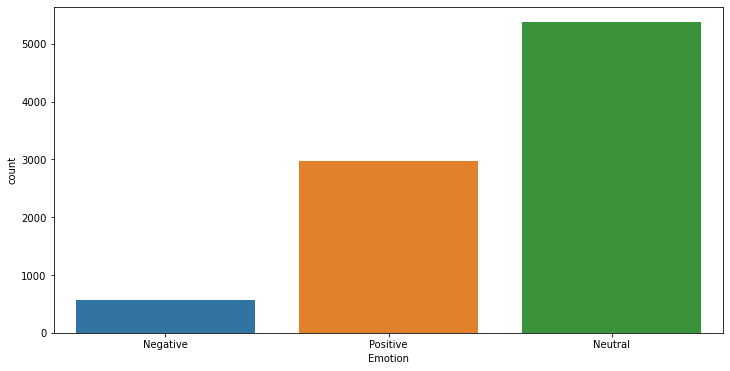

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x='Emotion',data=data)

In [25]:
# Filter the dataframe for positive, negative, and neutral emotions
positive_tweets = data[data['Emotion'] == 'Positive']['preprocessed_text']
negative_tweets = data[data['Emotion'] == 'Negative']['preprocessed_text']
neutral_tweets = data[data['Emotion'] == 'Neutral']['preprocessed_text']

# Concatenate all positive, negative, and neutral tweets into separate lists
all_positive_tokens = [token for sublist in positive_tweets for token in sublist]
all_negative_tokens = [token for sublist in negative_tweets for token in sublist]
all_neutral_tokens = [token for sublist in neutral_tweets for token in sublist]

# Create frequency distributions for positive, negative, and neutral tokens
positive_freq_dist = FreqDist(all_positive_tokens)
negative_freq_dist = FreqDist(all_negative_tokens)
neutral_freq_dist = FreqDist(all_neutral_tokens)

# Get the top 10 most common positive, negative, and neutral tokens and their frequencies
top_positive_tokens = positive_freq_dist.most_common(10)
top_negative_tokens = negative_freq_dist.most_common(10)
top_neutral_tokens = neutral_freq_dist.most_common(10)

tokens_positive, frequencies_positive = zip(*top_positive_tokens)
tokens_negative, frequencies_negative = zip(*top_negative_tokens)
tokens_neutral, frequencies_neutral = zip(*top_neutral_tokens)

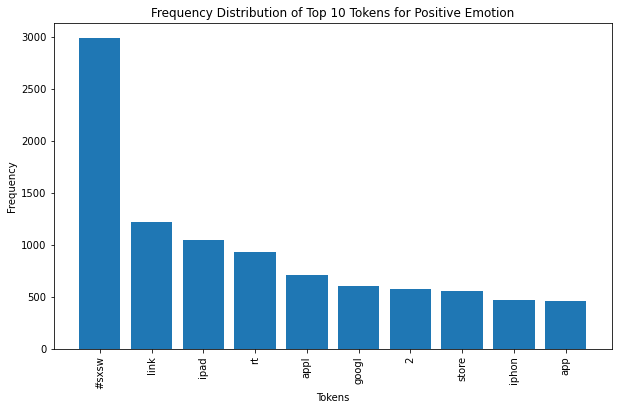

In [26]:
# Plot the frequency distribution of the most common tokens for positive emotion
plt.figure(figsize=(10, 6))
plt.bar(tokens_positive, frequencies_positive)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Top 10 Tokens for Positive Emotion')
plt.xticks(rotation=90)
plt.show()

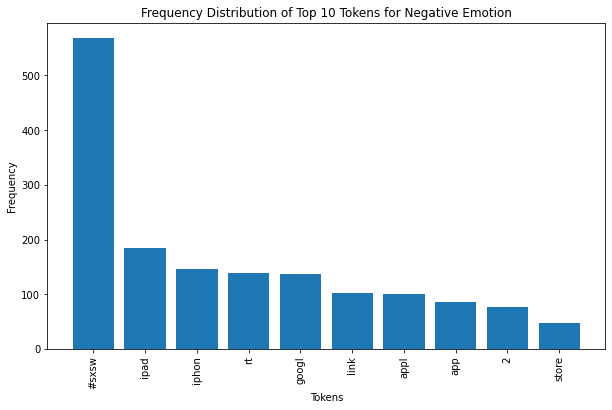

In [27]:
# Plot the frequency distribution of the most common tokens for negative emotion
plt.figure(figsize=(10, 6))
plt.bar(tokens_negative, frequencies_negative)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Top 10 Tokens for Negative Emotion')
plt.xticks(rotation=90)
plt.show()


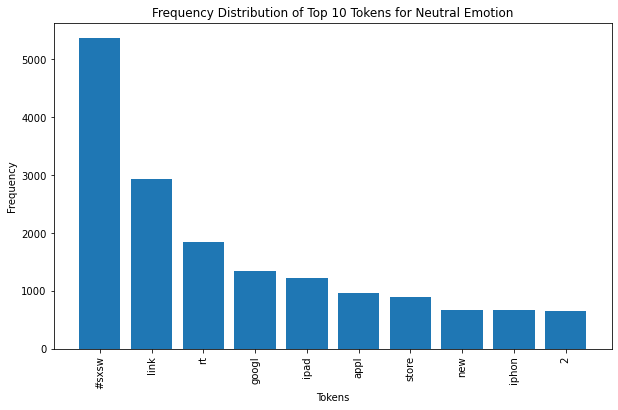

In [28]:
# Plot the frequency distribution of the most common tokens for neutral emotion
plt.figure(figsize=(10, 6))
plt.bar(tokens_neutral, frequencies_neutral)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Top 10 Tokens for Neutral Emotion')
plt.xticks(rotation=90)
plt.show()

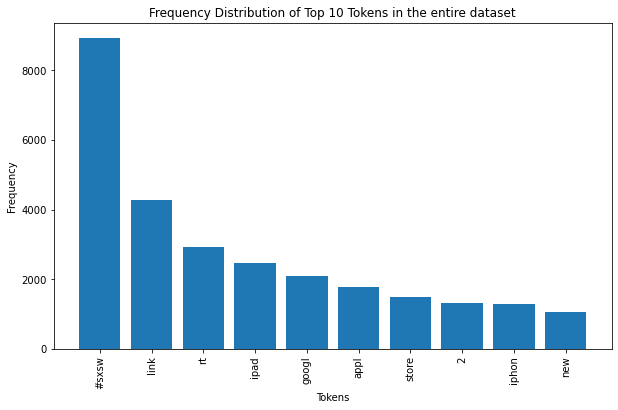

In [29]:
# Concatenate all preprocessed_text into a single list
all_tokens = [token for sublist in data["preprocessed_text"] for token in sublist]

# Create a frequency distribution of tokens
freq_dist = FreqDist(all_tokens)

# Get the top 10 most common tokens and their frequencies
top_tokens = freq_dist.most_common(10)
tokens, frequencies = zip(*top_tokens)
# Plot the frequency distribution in a bar graph
plt.figure(figsize=(10, 6))
plt.bar(tokens, frequencies)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Top 10 Tokens in the entire dataset')
plt.xticks(rotation=90)
plt.show()

## <b> Feature Engineering </b>

Groups Apple and Google products together. 

In [30]:
#mapping products to brands
brand_dict={'iPhone': 'Apple', 'iPad or iPhone App': 'Apple', 'iPad': 'Apple', 
            'Google': 'Google', 'Unknown': 'Unknown',
            'Android': 'Google', 'Apple': 'Apple', 'Android App': 'Google',
            'Other Google product or service': 'Google',
            'Other Apple product or service': 'Apple'}
data['Brand'] = data['Product/Brand'].map(brand_dict)
data['Brand'].unique()
data.head()

,Tweet,Product/Brand,Emotion,preprocessed_text,Brand
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[3g, iphon, 3, hr, tweet, #rise_austin, dead, need, upgrad, plugin, station, #sxsw]",Apple
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[know, awesom, ipad, iphon, app, like, appreci, design, also, they'r, give, free, ts, #sxsw]",Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[wait, #ipad, 2, also, sale, #sxsw]",Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year', festiv, crashi, year', iphon, app, #sxsw]",Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,"[great, stuff, fri, #sxsw, marissa, mayer, googl, tim, o'reilli, tech, book, confer, matt, mullenweg, wordpress]",Google


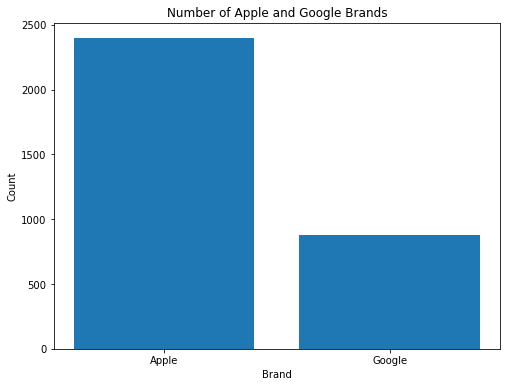

In [31]:
# Counts the number of Apple and Google brands
apple_count = data[data['Brand'] == 'Apple'].shape[0]
google_count = data[data['Brand'] == 'Google'].shape[0]

# Creates a bar graph of the brand counts
brands = ['Apple', 'Google']
counts = [apple_count, google_count]

plt.figure(figsize=(8, 6))
plt.bar(brands, counts)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Number of Apple and Google Brands')
plt.show()

<AxesSubplot:xlabel='Brand', ylabel='count'>

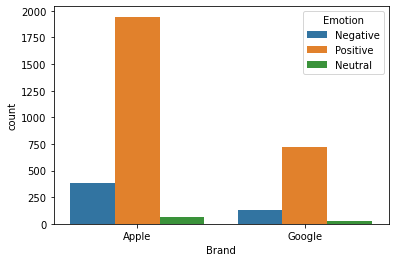

In [32]:
sns.countplot(data=data, x="Brand", hue="Emotion")

In [33]:
bigram_measures = BigramAssocMeasures()

# Flatten the list of lists into a single list
word_list = list(itertools.chain.from_iterable(data['preprocessed_text']))

tweet_finder = BigramCollocationFinder.from_words(word_list)
tweet_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)
tweet_scored[:50]


[(('ipad', '2'), 0.010138056191625415),
 (('link', '#sxsw'), 0.008104744078216005),
 (('#sxsw', 'link'), 0.007629671154522219),
 (('#sxsw', 'rt'), 0.006175948008019231),
 (('appl', 'store'), 0.005140289034366775),
 (('link', 'rt'), 0.0050832802835235205),
 (('social', 'network'), 0.004266154854770207),
 (('new', 'social'), 0.003829087764971923),
 (('googl', 'launch'), 0.003259000256539379),
 (('network', 'call'), 0.002964455043849231),
 (('call', 'circl'), 0.0028694404591104736),
 (('rt', 'googl'), 0.0027649244158978402),
 (('appl', 'open'), 0.002736420040476213),
 (('major', 'new'), 0.0027174171235284615),
 (('#sxsw', 'appl'), 0.002641405455737456),
 (('launch', 'major'), 0.002641405455737456),
 (('store', '#sxsw'), 0.00256539378794645),
 (('pop-up', 'store'), 0.002441874827786065),
 (('austin', '#sxsw'), 0.0024133704523644378),
 (('link', 'via'), 0.002375364618468935),
 (('today', 'link'), 0.002365863159995059),
 (('#sxsw', 'ipad'), 0.0022233412828869233),
 (('iphon', 'app'), 0.00221

In [34]:
# Word Frequency 

# Modelling

In [35]:
# Binary dataframe
data_binary = data.loc[(data['Emotion'] == 'Positive' ) | (data['Emotion'] == 'Negative' )]
data_binary

,Tweet,Product/Brand,Emotion,preprocessed_text,Brand
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[3g, iphon, 3, hr, tweet, #rise_austin, dead, need, upgrad, plugin, station, #sxsw]",Apple
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[know, awesom, ipad, iphon, app, like, appreci, design, also, they'r, give, free, ts, #sxsw]",Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[wait, #ipad, 2, also, sale, #sxsw]",Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year', festiv, crashi, year', iphon, app, #sxsw]",Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,"[great, stuff, fri, #sxsw, marissa, mayer, googl, tim, o'reilli, tech, book, confer, matt, mullenweg, wordpress]",Google
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,iPhone,Positive,"[pr, guy, convinc, switch, back, iphon, great, #sxsw, coverag, #princess]",Apple
9079,&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle,iPad,Positive,"[papyru, ..., sort, like, ipad, nice, lol, #sxsw, lavel]",Apple
9080,"Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essentially ready today.&quot; #sxsw #diller",Other Google product or service,Negative,"[diller, say, googl, tv, might, run, playstat, xbox, essenti, readi, today, #sxsw, #diller]",Google
9085,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,iPad or iPhone App,Positive,"[i'v, alway, use, camera, iphon, b, c, imag, stabil, mode, suggest, ipad, cam, app, w, featur, #sxsw, #sxswi]",Apple


In [36]:
# Relabeling the content of the emotion column
data_binary.loc[data_binary['Emotion'] == 'Positive' , 'emotion_label'] = 0
data_binary.loc[data_binary['Emotion'] == 'Negative' , 'emotion_label'] = 1
data_binary

,Tweet,Product/Brand,Emotion,preprocessed_text,Brand,emotion_label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[3g, iphon, 3, hr, tweet, #rise_austin, dead, need, upgrad, plugin, station, #sxsw]",Apple,1.0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[know, awesom, ipad, iphon, app, like, appreci, design, also, they'r, give, free, ts, #sxsw]",Apple,0.0
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[wait, #ipad, 2, also, sale, #sxsw]",Apple,0.0
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year', festiv, crashi, year', iphon, app, #sxsw]",Apple,1.0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,"[great, stuff, fri, #sxsw, marissa, mayer, googl, tim, o'reilli, tech, book, confer, matt, mullenweg, wordpress]",Google,0.0
...,...,...,...,...,...,...
9077,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,iPhone,Positive,"[pr, guy, convinc, switch, back, iphon, great, #sxsw, coverag, #princess]",Apple,0.0
9079,&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle,iPad,Positive,"[papyru, ..., sort, like, ipad, nice, lol, #sxsw, lavel]",Apple,0.0
9080,"Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essentially ready today.&quot; #sxsw #diller",Other Google product or service,Negative,"[diller, say, googl, tv, might, run, playstat, xbox, essenti, readi, today, #sxsw, #diller]",Google,1.0
9085,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,iPad or iPhone App,Positive,"[i'v, alway, use, camera, iphon, b, c, imag, stabil, mode, suggest, ipad, cam, app, w, featur, #sxsw, #sxswi]",Apple,0.0


In [37]:
# Split the data -- Train and Test

from sklearn.model_selection import train_test_split
data['joined_preprocessed_text'] = data['preprocessed_text'].str.join(" ")
X_train, X_test, y_train, y_test = train_test_split(data['joined_preprocessed_text'], data.
                                                   Emotion, test_size = 0.3, 
                                                    random_state=20)
X_train

3397                    i10 march pig link code valid 12:00- 3:59 59p 03/12 11 #infektd #sxsw #zomb
4321    lol rt i'll bet there' lot nerd #sxsw use #iphon light saber app barroom brawl instead fist
4091                                    #appl ipad per capit #sxsw anywher els world except foxconn
6378          rt umbrella list via  ÷ ¼ set  ÷ link  ÷ #edchat #musedchat #sxsw #sxswi #newtwitt
5207           rt #appl head sxsw set temporari store #austin link #new #sxsw bastard bring temptat
                                                   ...                                             
6030                 rt hoot new blog post hootsuit mobil #sxsw updat iphon blackberri android link
3994                                      hannukah miracl morn uncharg iphon still 55 batteri #sxsw
7208           alarm go allow user gener content say google' richard salgado #privacybootcamp #sxsw
7540                                         head ipad design headach 2 tablet call morn #sxsw link


In [38]:
# Split the data -- Train and Test

from sklearn.model_selection import train_test_split
data_binary['joined_preprocessed_text'] = data_binary['preprocessed_text'].str.join(" ")
X_train, X_test, y_train, y_test = train_test_split(data_binary['joined_preprocessed_text'], data_binary.
                                                   Emotion, test_size = 0.3, 
                                                    random_state=20)
X_train

5377    rt agre  ûó novelti #ipad news #app fade fast among digit deleg  ûó link #media #sxsw via
6874                                                rt includ emot thing ipad #barrydil #sxsw #pnid
8683                 pick mophi iphon charg case #sxsw tradeshow doubt i'll use time great long day
6147                                                                rt ipad 2 queue epic #sxsw link
6759                    rt new whrrl app live iphon app store android marketplac get hot time #sxsw
                                                   ...                                             
7601                                               dear lanyrd site awesom use #sxsw wish iphon app
8436                           saw huge ipad 2 line popup appl store peopl realli realli want #sxsw
626          wonder much revenu austin store gross account ipad 2 amid #sxsw ... strateg releas ...
6349                               rt new #ubersoci #iphon app store includ uberguid #sxsw link got


In [39]:
# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

# Get the feature names from the vectorizer
feature_names = tfidf.get_feature_names()

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=feature_names)

,app,appl,googl,ipad,iphon,link,new,rt,store,sxsw
0,0.609007,0.000000,0.0,0.429649,0.000000,0.421569,0.000000,0.472228,0.000000,0.209265
1,0.000000,0.000000,0.0,0.639496,0.000000,0.000000,0.000000,0.702872,0.000000,0.311473
2,0.000000,0.000000,0.0,0.000000,0.934017,0.000000,0.000000,0.000000,0.000000,0.357229
3,0.000000,0.000000,0.0,0.541689,0.000000,0.531503,0.000000,0.595372,0.000000,0.263835
4,0.723758,0.000000,0.0,0.000000,0.325121,0.000000,0.398759,0.280603,0.342435,0.124347
...,...,...,...,...,...,...,...,...,...,...
2472,0.720705,0.000000,0.0,0.000000,0.647499,0.000000,0.000000,0.000000,0.000000,0.247646
2473,0.000000,0.544773,0.0,0.481253,0.000000,0.000000,0.000000,0.000000,0.645503,0.234399
2474,0.000000,0.000000,0.0,0.573889,0.000000,0.000000,0.000000,0.000000,0.769754,0.279518
2475,0.442144,0.000000,0.0,0.000000,0.397233,0.306063,0.487205,0.342842,0.418388,0.151928


### Baseline Model

In [40]:
#instantiate
baseline_model = MultinomialNB()

baseline_model.fit(X_train_vectorized,y_train)
baseline_train_score = baseline_model.score(X_train_vectorized,y_train)
print(baseline_train_score)

0.8364957610012111


In [41]:
# imbalanced
y_train.value_counts(normalize=True)

Positive    0.836496
Negative    0.163504
Name: Emotion, dtype: float64

In [42]:
# Balancing the model
ROS = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ROS.fit_resample(X_train_vectorized, y_train)

In [43]:
y_train_ros.value_counts(normalize=True)

Negative    0.5
Positive    0.5
Name: Emotion, dtype: float64

### Model 2

In [44]:

# Balancing the model
ROS = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ROS.fit_resample(X_train_vectorized, y_train)

In [45]:
y_train_ros.value_counts(normalize=True)

Negative    0.5
Positive    0.5
Name: Emotion, dtype: float64

In [46]:
model2 = MultinomialNB()

model2.fit(X_train_ros, y_train_ros)
train_score2 = model2.score(X_train_ros, y_train_ros)
print(train_score2)

0.590492277992278


In [47]:

model2_train_predictions = model2.predict(X_train_ros)
model2_f1 = f1_score(y_train_ros, model2_train_predictions, pos_label='Positive')

print(model2_f1)

0.5781754909271688


### Multiclass Classification

In [48]:
# After running a Binary classification we will also look at Multiclass Classification 
# see how it performs on the data. 
# We will start with preparing data for multiclass
# Che the data column of Emotion
data['Emotion'].unique()



array(['Negative', 'Positive', 'Neutral'], dtype=object)

In [49]:
# We will assign numerical values to the sentiments,
# Neutral = 1
# Positive = 2
# Negarive = 0
#mapping emotion column to numerical values
emotion_dict = {'Negative': 0, 'Neutral':1, 'Positive': 2}
data['Emotion'] = data['Emotion'].map(emotion_dict)
data['Emotion'].value_counts()


1    5375
2    2970
0     569
Name: Emotion, dtype: int64

In [50]:
# Define the X and y objects 
X = data['Tweet']
y = data['Emotion']

# split into train and test objects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# check the y_train values 
y_train.value_counts(normalize=True)

1    0.602721
2    0.333894
0    0.063385
Name: Emotion, dtype: float64

In [51]:
# Creating a multiclass classification that take in y_true as the vlues of y_test, y_pred, initial classifier, X_test and X_trai

def multiclass_eval(y_true, y_pred, X_test, X_train, clf, n_class=3):
    print(f"Training score: {clf.score(X_train, y_train)}\
        Test Score:{clf.score(X_test, y_test)}")
    
    # Print classication report
    print('\n')
    print('Classifictaion Report')
    print('_______________________________________')
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
    # Create a figure/axes for confusion matrix and ROC curve
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
    # Plot the normalized confusion matrix
    plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_true, cmap='BrBG_r', 
                          normalize='true', ax=ax[0], 
                          display_labels=['Negative', 'Neutral', 'Positive'])
    
    pred_prob = clf.predict_proba(X_test)
    
    # Plot the ROC curve
    fpr={}
    tpr={}
    thresh={}
    
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, pred_prob[:,i], pos_label=i)
    
    ax[1].plot(fpr[0], tpr[0], linestyle='--',color='red', label='Negative')
    ax[1].plot(fpr[1], tpr[1], linestyle='--',color='black', label='Neutral')
    ax[1].plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Positive')
    ax[1].set_title('Multiclass ROC curve')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive rate')
    ax[1].legend(loc='best')
    
    
    ax[1].plot([0,1], [0,1], ls='--', color='cyan')

#### <span style='color:cyan'>**Dummy Model**</SPAN>

Training score: 0.48548590660496427        Test Score:0.4699943914750421


Classifictaion Report
_______________________________________
              precision    recall  f1-score   support

           0       0.08      0.09      0.08       117
           1       0.59      0.60      0.60      1077
           2       0.32      0.32      0.32       589

    accuracy                           0.47      1783
   macro avg       0.33      0.33      0.33      1783
weighted avg       0.47      0.47      0.47      1783



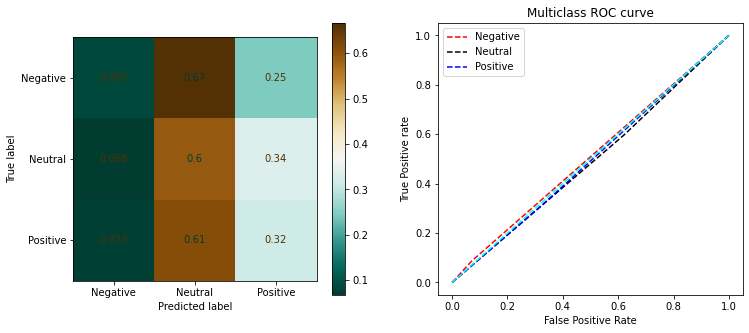

In [52]:
# Create a Dummy model for Multiclass

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopwords_list)), 
    ('clf', DummyClassifier(random_state=42))
])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe)

The above outcome show class imbalance and that is why we have more neutrals comming out as the majority followed by positives and then negatives.

This reflects back to the our classes on the value counts in the `Emotion` column. Class imbalance can affect our model by being biased towords the majority in the values. Meaning any time we run our model it has 60% chances of selecting a neutral sentiment, 33% chances of selecting a positive sentiment and 6% chances of selecting a negative sentiment. 

Class imbalance can be addressed by `Oversampling` method. In the next cell we will do random oversampling and then split the data and run a model to see how it will perform. 

Training score: 0.3274435563034637        Test Score:0.33426808749298936


Classifictaion Report
_______________________________________
              precision    recall  f1-score   support

           0       0.06      0.30      0.10       117
           1       0.60      0.34      0.44      1077
           2       0.33      0.32      0.32       589

    accuracy                           0.33      1783
   macro avg       0.33      0.32      0.29      1783
weighted avg       0.48      0.33      0.38      1783



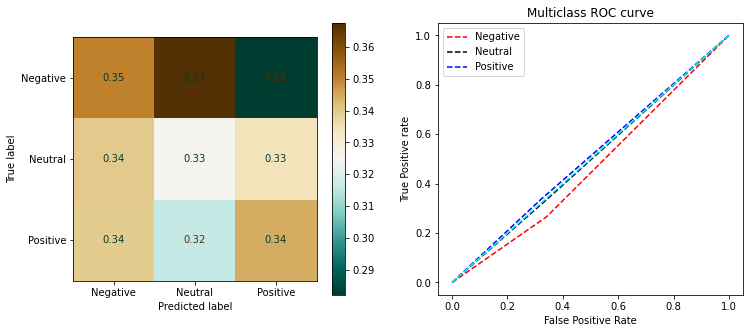

In [53]:
# Random Classifier 

clf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopwords_list)),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', DummyClassifier())
])
clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe)

From the observation above it looks like the model is now able to levelup the sentiments and any sentment has equal chances to be selected. 


### <span style='color:cyan'> **Logistic Regression.**</SPAN>

Training score: 0.9389987379049222        Test Score:0.6713404374649468


Classifictaion Report
_______________________________________
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       117
           1       0.76      0.73      0.75      1077
           2       0.57      0.61      0.59       589

    accuracy                           0.67      1783
   macro avg       0.58      0.58      0.58      1783
weighted avg       0.68      0.67      0.67      1783



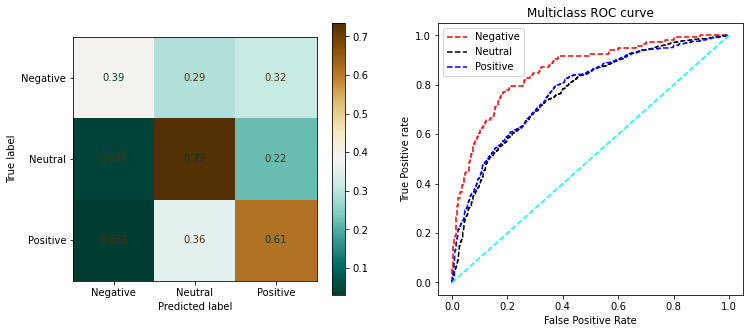

In [54]:

# Create a pipeline baseline logistic Regression
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopwords_list)), 
    ('clf', LogisticRegressionCV(class_weight='balanced', random_state=42, 
                                 cv=3))
])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe)

Without tuning our model was able to classifie about 67% on the on the unseen data. This is a better model compaired to the dummy model, although there is some sort of overfitting the training data. Next we will look for the way to reduce the overfitting by the use of GridSearchCV. 

#### <span style='color:orange'>**Hyperparameter Tuning with GridSearchCV.**</SPAN>

In [55]:
# Greating a GridSearchCV

param_grid = {
    'clf__class_weight': ['balanced'], 
    'clf__max_iter': [2, 5],
    'clf__Cs': [0.1, 1],
    'clf__solver': ['liblinear', 'lbfgs', 'sag']
}

gs_lr = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, scoring='recall_macro')
gs_lr.fit(X_train, y_train)
gs_lr.best_params_

{'clf__Cs': 1,
 'clf__class_weight': 'balanced',
 'clf__max_iter': 2,
 'clf__solver': 'lbfgs'}

Training score: 0.5352685457860048        Test Score:0.5272013460459899


Classifictaion Report
_______________________________________
              precision    recall  f1-score   support

           0       0.15      0.70      0.25       117
           1       0.77      0.56      0.65      1077
           2       0.57      0.43      0.49       589

    accuracy                           0.53      1783
   macro avg       0.50      0.56      0.46      1783
weighted avg       0.66      0.53      0.57      1783



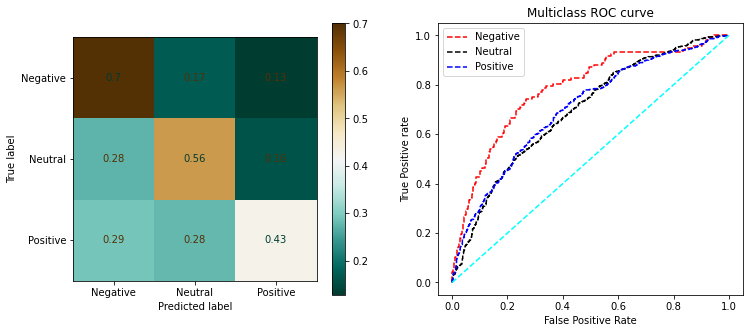

In [56]:
# Creating a pipeline model
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopwords_list)), 
    ('clf', LogisticRegressionCV(class_weight='balanced', Cs = [1], 
                                 random_state=42, max_iter=2,
                                 solver='lbfgs',
                                 cv=3))
])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe)

After tuning the OverSampled Logistic Regression we were able to reducing the overfitting although the model accuracy reduced from 67% (baseline logistic regrssion) to 53% on the test data set. 

#### <span style='color:cyan'>**Random Forest Classifier.**</SPAN>

Training score: 0.995793016407236        Test Score:0.6803140773976444


Classifictaion Report
_______________________________________
              precision    recall  f1-score   support

           0       0.60      0.21      0.31       117
           1       0.72      0.81      0.76      1077
           2       0.59      0.54      0.57       589

    accuracy                           0.68      1783
   macro avg       0.64      0.52      0.55      1783
weighted avg       0.67      0.68      0.67      1783



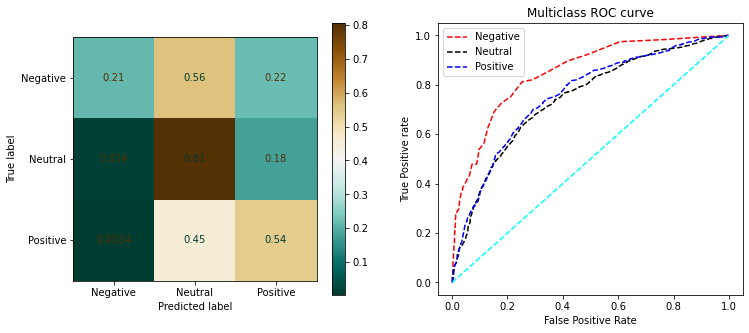

In [57]:
# Creating RandomOversampler Random Forest Classifier
rf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopwords_list)),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, rf_pipe)

The model performed better than the RandomOversampled Logistic Regrssion and the tuned one with 68% accuracy although slightly overfitting on the training dataset. 

#### <span style='color:orange'>**Hyperparameter Tuning with GridSearchCV**</SPAN>

In [58]:

# Performing a GridSearch to determine best parametors. 
param_grid = {
    'clf__criterion': ['gini', 'entropy'], 
    'clf__max_depth': [2, 5, 10],
    'clf__min_samples_split': [1, 5, 10, 20],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__n_estimators':[50, 100]
}

gs_rf = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, scoring='recall_macro')
gs_rf.fit(X_train, y_train)
gs_rf.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 10,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 10,
 'clf__n_estimators': 100}

Training score: 0.5058196606366568        Test Score:0.5008412787436904


Classifictaion Report
_______________________________________
              precision    recall  f1-score   support

           0       0.13      0.72      0.22       117
           1       0.76      0.53      0.63      1077
           2       0.61      0.40      0.48       589

    accuracy                           0.50      1783
   macro avg       0.50      0.55      0.44      1783
weighted avg       0.67      0.50      0.55      1783



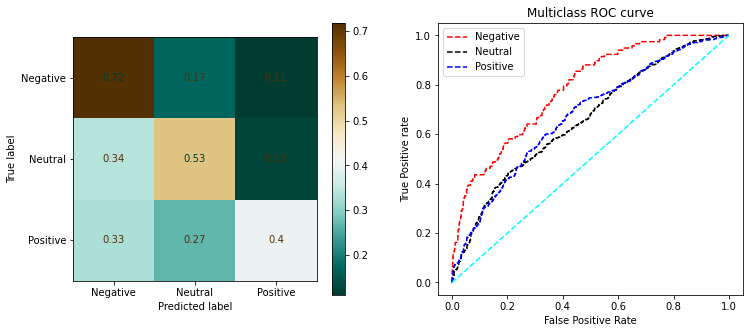

In [59]:
rf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopwords_list)),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', 
                                   criterion='entropy',
                                   max_depth=10,
                                   min_samples_leaf=10,
                                   min_samples_split=10,
                                   n_estimators=100))
])
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, rf_pipe)

GridSearchCV tuning wa able to reduce overfitting on the training data but also reduced the accuracy on the testing data. 

# Conclusion